In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import jsonpickle

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [2]:
RUNDIR = "../output"
RUNID = "20240218_205700"

In [3]:
config_files = list(Path(RUNDIR).glob(f"{RUNID}*.config.json"))
print(f"Found {len(config_files)} config files")

Found 15 config files


In [4]:
configs = {}
dfs = {}
for config_file in config_files:
    config = jsonpickle.decode(config_file.read_text())
    data_file = Path(RUNDIR, config_file.name.split(".")[0] + ".csv")
    sub_id = config_file.name.split(".")[0].split("_")[-1]
    
    data = pd.read_csv(data_file)
    data["id"] = sub_id
    data["algorithm"] = config["algorithm"]
    data["dataset"] = config["dataset"]
    data["imbalance"] = config["imbalance_type"]
    data["imbalance_val"] = config["imbalance_value"]
    data["is_last_round"] = data["round"] == (config["rounds"] - 1)
    
    if sub_id in configs:
        print("Duplicate id!")
    dfs[sub_id] = data
    configs[sub_id] = config
    
data = pd.concat(dfs.values(), axis=0)
cluster_assignments = data.query("stage == 'test' and variable == 'cluster_identities'") 
data = data.query("variable != 'cluster_identities'")
data["value"] = data["value"].astype(float)

In [5]:
configs["0"]

{'algorithm': 'IFCA',
 'dataset': 'mnist',
 'rounds': 200,
 'epochs': 10,
 'n_clients': 100,
 'clients_per_round': 1.0,
 'imbalance_type': 'label_distribution',
 'imbalance_value': 0.1,
 'clusters': 5,
 'clusters_per_client': 1}

In [6]:
data["variable"].unique()

array(['loss', 'n_samples', 'f1'], dtype=object)

In [7]:
data = data.pivot_table(values = "value", index = ["round", "client", "stage", "id", "algorithm", "dataset", "imbalance", "imbalance_val", "is_last_round"], columns = ["variable"]).reset_index()
data.head()

variable,round,client,stage,id,algorithm,dataset,imbalance,imbalance_val,is_last_round,f1,loss,n_samples
0,0,0,test,0,IFCA,mnist,label_distribution,0.1,False,0.046877,2.284374,89.0
1,0,0,test,1,IFCA,mnist,label_distribution,3.0,False,0.013559,2.313822,110.0
2,0,0,test,11,IFCA,mnist,label_distribution,1.0,False,0.078810,2.276573,68.0
3,0,0,test,12,local,mnist,label_distribution,0.1,False,0.181818,0.025496,89.0
4,0,0,test,14,FLSC,mnist,label_distribution,1.0,False,0.025573,2.296313,68.0


In [40]:
df = data.query("stage == 'test' and algorithm == 'FedAvg'")
df["weighted_f1"] = df["f1"] * df["n_samples"]
df["weighted_loss"] = df["loss"] * df["n_samples"]
df = df.drop(columns=["client", "stage", "id", "dataset", "imbalance", "is_last_round", "algorithm"])\
    .groupby(["round", "imbalance_val"])\
    .sum()\
    .reset_index()

df["weighted_f1"] = df["weighted_f1"] / df["n_samples"]
df["weighted_loss"] = df["weighted_loss"] / df["n_samples"]

df = df.drop(columns=["loss", "f1"])
df

/tmp/ipykernel_28525/2553739235.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_28525/2553739235.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



variable,round,imbalance_val,n_samples,weighted_f1,weighted_loss
0,1,0.1,11964.0,0.677829,0.242465
1,1,1.0,11964.0,0.621538,0.838052
2,1,3.0,11959.0,0.627253,1.074250
3,2,0.1,11964.0,0.762523,0.098000
4,2,1.0,11964.0,0.837802,0.261699
...,...,...,...,...,...
595,199,1.0,11964.0,0.810647,0.355411
596,199,3.0,11959.0,0.864849,0.354628
597,200,0.1,11964.0,0.752172,0.111931
598,200,1.0,11964.0,0.806808,0.343550


<Axes: xlabel='round', ylabel='weighted_f1'>

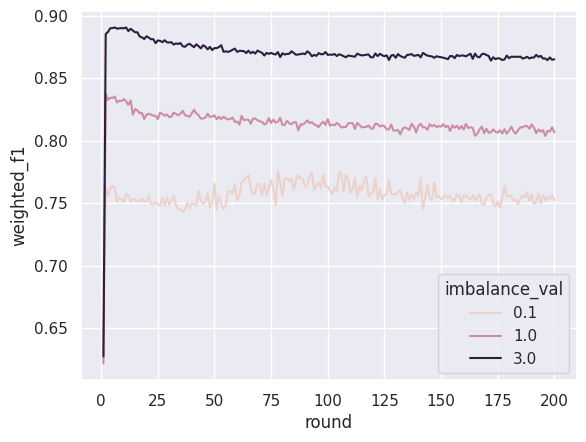

In [41]:
sns.lineplot(df, x = "round", y="weighted_f1", hue="imbalance_val")

<Axes: xlabel='round', ylabel='weighted_loss'>

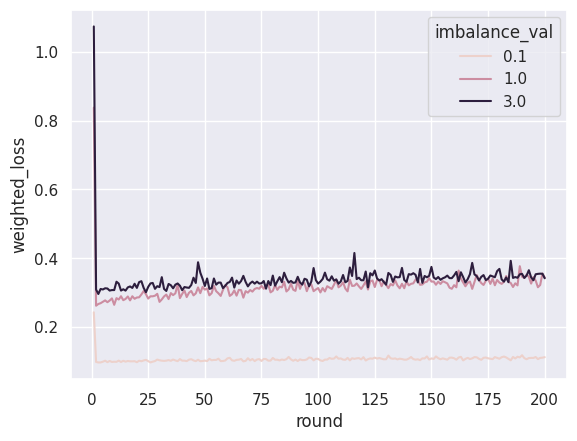

In [42]:
sns.lineplot(df, x = "round", y="weighted_loss", hue="imbalance_val")

<Axes: xlabel='round', ylabel='loss'>

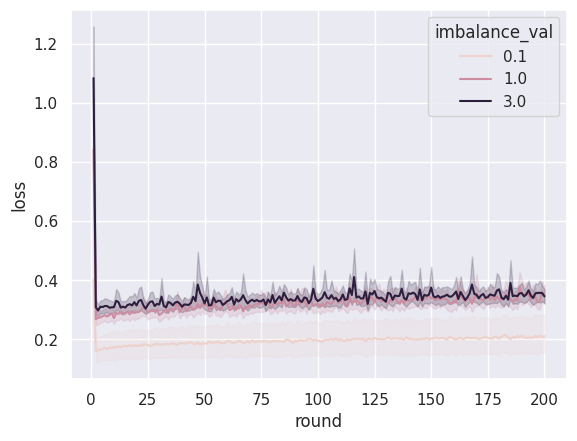

In [43]:
df = data.query("stage == 'test' and algorithm == 'FedAvg'")
sns.lineplot(df, x = "round", y = "loss", hue = "imbalance_val")

<Axes: xlabel='round', ylabel='f1'>

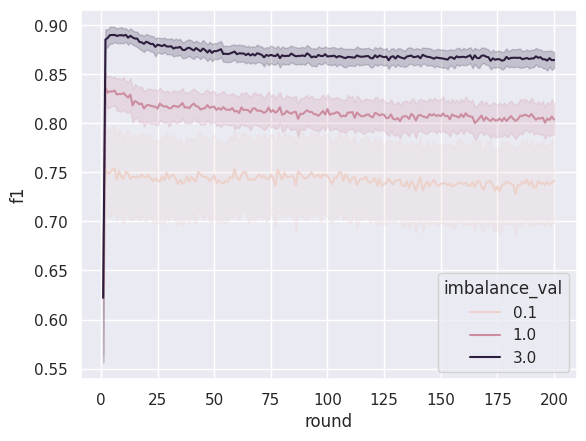

In [44]:
df = data.query("stage == 'test' and algorithm == 'FedAvg'")
sns.lineplot(df, x = "round", y = "f1", hue = "imbalance_val")

In [13]:
df_last = data.query("stage == 'test' and is_last_round")
df_last

variable,round,client,stage,id,algorithm,dataset,imbalance,imbalance_val,is_last_round,f1,loss,n_samples
595800,199,0,test,0,IFCA,mnist,label_distribution,0.1,True,0.444251,0.885889,89.0
595801,199,0,test,1,IFCA,mnist,label_distribution,3.0,True,0.805910,0.543736,110.0
595802,199,0,test,10,FedProx,mnist,label_distribution,3.0,True,0.853417,0.316936,110.0
595803,199,0,test,11,IFCA,mnist,label_distribution,1.0,True,0.660295,0.780140,68.0
595804,199,0,test,12,local,mnist,label_distribution,0.1,True,0.759692,0.004254,89.0
...,...,...,...,...,...,...,...,...,...,...,...,...
598780,199,99,test,5,FedProx,mnist,label_distribution,0.1,True,1.000000,0.003573,208.0
598781,199,99,test,6,local,mnist,label_distribution,3.0,True,1.000000,0.000003,123.0
598782,199,99,test,7,FedAvg,mnist,label_distribution,0.1,True,1.000000,0.003741,208.0
598783,199,99,test,8,FedAvg,mnist,label_distribution,1.0,True,0.993117,0.930247,130.0


Text(0.5, 1.0, 'Avg. F1 scores by imbalance param')

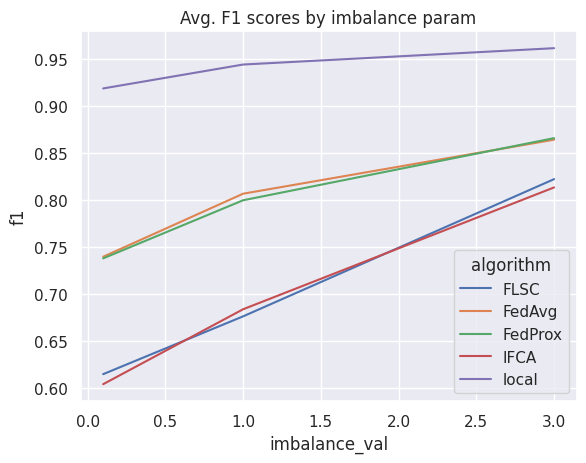

In [14]:
df_last_avg = df_last.groupby(["imbalance", "imbalance_val", "algorithm"]).mean(["f1", "loss"]).reset_index()\
    .query("imbalance == 'label_distribution'")
sns.lineplot(df_last_avg, x="imbalance_val", y="f1", hue='algorithm')
plt.title("Avg. F1 scores by imbalance param")

In [15]:
algorithms = set(df_last["algorithm"].unique()).difference({"local", "global"})
benefits = df_last.reset_index(drop=True)[["stage", "round", "client", "algorithm", "dataset", "imbalance", "imbalance_val", "f1"]]
benefits = benefits.pivot(columns="algorithm", values="f1", index=["stage", "round", "client", "dataset", "imbalance", "imbalance_val"]).reset_index()
benefits

algorithm,stage,round,client,dataset,imbalance,imbalance_val,FLSC,FedAvg,FedProx,IFCA,local
0,test,199,0,mnist,label_distribution,0.1,0.446840,0.687258,0.587279,0.444251,0.759692
1,test,199,0,mnist,label_distribution,1.0,0.645462,0.782499,0.861417,0.660295,0.765078
2,test,199,0,mnist,label_distribution,3.0,0.809280,0.859516,0.853417,0.805910,0.886277
3,test,199,1,mnist,label_distribution,0.1,0.330035,0.721556,0.749666,0.330035,0.749666
4,test,199,1,mnist,label_distribution,1.0,0.534443,0.596596,0.591929,0.542782,0.781060
...,...,...,...,...,...,...,...,...,...,...,...
295,test,199,98,mnist,label_distribution,1.0,0.743980,0.731622,0.728354,0.770940,0.956463
296,test,199,98,mnist,label_distribution,3.0,0.880751,0.895242,0.902079,0.873153,0.995634
297,test,199,99,mnist,label_distribution,0.1,1.000000,1.000000,1.000000,1.000000,0.995083
298,test,199,99,mnist,label_distribution,1.0,0.932497,0.993117,0.986839,0.978456,0.993117


In [16]:
local = df_last.query("algorithm == 'local'")[["client","imbalance","imbalance_val","f1"]]
fedavg = df_last.query("algorithm == 'FedAvg'")[["client","imbalance","imbalance_val","f1"]]
fedprox = df_last.query("algorithm == 'FedProx'")[["client","imbalance","imbalance_val","f1"]]
ifca = df_last.query("algorithm == 'IFCA'")[["client","imbalance","imbalance_val","f1"]]
flsc = df_last.query("algorithm == 'FLSC'")[["client","imbalance","imbalance_val","f1"]]

In [17]:
f1scores = ifca.merge(flsc, on=["client", "imbalance", "imbalance_val"], suffixes=["_ifca", "_flsc"])\
    .merge(fedavg, on=["client", "imbalance", "imbalance_val"])\
    .merge(local, on=["client", "imbalance", "imbalance_val"], suffixes=["_fedavg", "_local"])\
    .merge(fedprox, on=["client", "imbalance", "imbalance_val"])\
    .rename(columns={"f1": "f1_fedprox"})
f1scores = f1scores.query("imbalance == 'label_distribution'")
f1scores

variable,client,imbalance,imbalance_val,f1_ifca,f1_flsc,f1_fedavg,f1_local,f1_fedprox
0,0,label_distribution,0.1,0.444251,0.446840,0.687258,0.759692,0.587279
1,0,label_distribution,3.0,0.805910,0.809280,0.859516,0.886277,0.853417
2,0,label_distribution,1.0,0.660295,0.645462,0.782499,0.765078,0.861417
3,1,label_distribution,0.1,0.330035,0.330035,0.721556,0.749666,0.749666
4,1,label_distribution,3.0,0.821654,0.858682,0.876876,0.930132,0.845959
...,...,...,...,...,...,...,...,...
295,98,label_distribution,3.0,0.873153,0.880751,0.895242,0.995634,0.902079
296,98,label_distribution,1.0,0.770940,0.743980,0.731622,0.956463,0.728354
297,99,label_distribution,0.1,1.000000,1.000000,1.000000,0.995083,1.000000
298,99,label_distribution,3.0,0.971290,0.964144,0.970437,1.000000,0.986149


In [18]:
f1scores["benefit_fedavg"] = f1scores["f1_fedavg"] - f1scores["f1_local"]
f1scores["benefit_fedprox"] = f1scores["f1_fedprox"] - f1scores["f1_local"]
f1scores["benefit_ifca"] = f1scores["f1_ifca"] - f1scores["f1_local"]
f1scores["benefit_flsc"] = f1scores["f1_flsc"] - f1scores["f1_local"]

In [19]:
benefits = f1scores.drop(columns=["f1_local", "f1_fedavg", "f1_ifca", "f1_flsc", "f1_fedprox"]).melt(id_vars=["client", "imbalance", "imbalance_val"], value_name="client_benefit", var_name="algorithm")

<Axes: xlabel='client_benefit', ylabel='Count'>

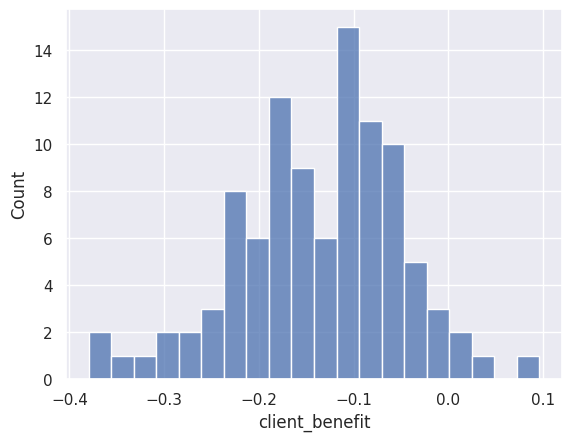

In [20]:
sns.histplot(benefits.query("algorithm == 'benefit_fedavg' and imbalance_val == 1"), x = "client_benefit", bins=20)

In [21]:
avg_benefits = benefits.groupby(["imbalance", "imbalance_val", "algorithm"]).mean().reset_index()
avg_benefits

,imbalance,imbalance_val,algorithm,client,client_benefit
0,label_distribution,0.1,benefit_fedavg,49.5,-0.179026
1,label_distribution,0.1,benefit_fedprox,49.5,-0.180754
2,label_distribution,0.1,benefit_flsc,49.5,-0.303903
3,label_distribution,0.1,benefit_ifca,49.5,-0.314571
4,label_distribution,1.0,benefit_fedavg,49.5,-0.137396
5,label_distribution,1.0,benefit_fedprox,49.5,-0.144370
6,label_distribution,1.0,benefit_flsc,49.5,-0.267845
7,label_distribution,1.0,benefit_ifca,49.5,-0.260293
8,label_distribution,3.0,benefit_fedavg,49.5,-0.097320
9,label_distribution,3.0,benefit_fedprox,49.5,-0.095669


<Axes: xlabel='imbalance_val', ylabel='client_benefit'>

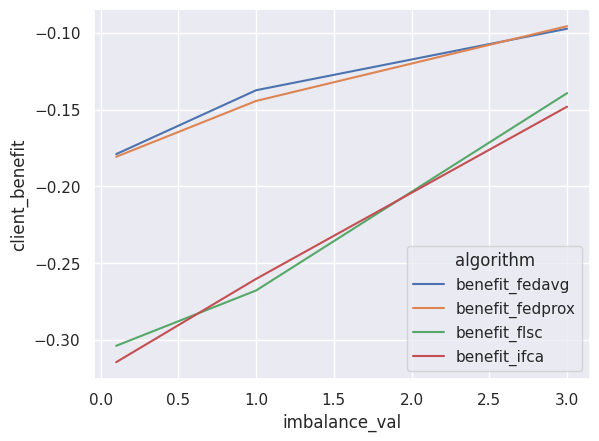

In [22]:
sns.lineplot(avg_benefits, x="imbalance_val", y="client_benefit", hue="algorithm")

## Benefit per Client

In [34]:
dataset = "mnist"
imbalance = "label_distribution"
imbalance_val = 1
# df = f1scores.query(f"imbalance == '{imbalance}' and imbalance_val >= {imbalance_val}")
df = f1scores.query(f"imbalance == '{imbalance}'")
imbalances = pd.read_csv(Path(RUNDIR, RUNID + "_data.csv"))
df = df.merge(imbalances)
df.head()

,client,imbalance,imbalance_val,f1_ifca,f1_flsc,f1_fedavg,f1_local,f1_fedprox,benefit_fedavg,benefit_fedprox,benefit_ifca,benefit_flsc,dataset,imbalance_type,imbalance_value,label_imbalance,label_distribution_imbalance,quantity_imbalance
0,0,label_distribution,0.1,0.444251,0.44684,0.687258,0.759692,0.587279,-0.072434,-0.172413,-0.315441,-0.312852,mnist,label_distribution,0.1,195.000000,0.457690,0.748333
1,0,label_distribution,0.1,0.444251,0.44684,0.687258,0.759692,0.587279,-0.072434,-0.172413,-0.315441,-0.312852,mnist,label_distribution,3.0,3.846154,0.082238,0.918333
2,0,label_distribution,0.1,0.444251,0.44684,0.687258,0.759692,0.587279,-0.072434,-0.172413,-0.315441,-0.312852,mnist,label_distribution,1.0,48.500000,0.254510,0.573333
3,0,label_distribution,3.0,0.805910,0.80928,0.859516,0.886277,0.853417,-0.026760,-0.032860,-0.080366,-0.076996,mnist,label_distribution,0.1,195.000000,0.457690,0.748333
4,0,label_distribution,3.0,0.805910,0.80928,0.859516,0.886277,0.853417,-0.026760,-0.032860,-0.080366,-0.076996,mnist,label_distribution,3.0,3.846154,0.082238,0.918333


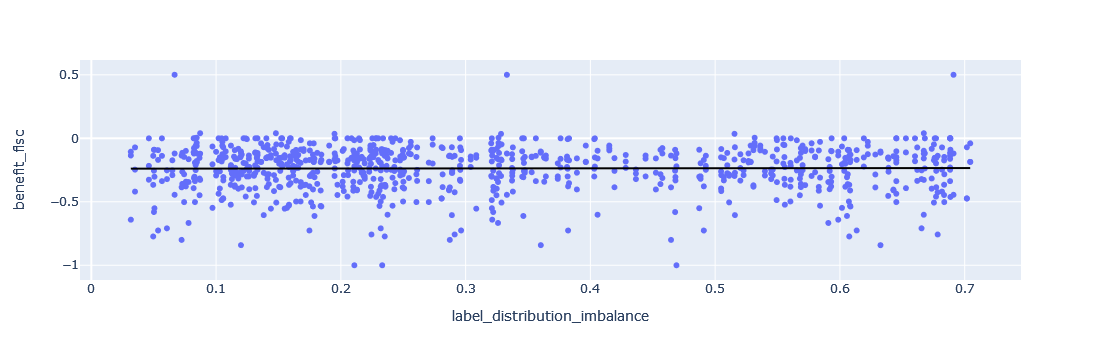

In [39]:
import plotly.express as px
px.scatter(df, x="label_distribution_imbalance", y="benefit_flsc", trendline='ols', trendline_color_override="black")

## Cluster Assignments

In [25]:
n_clusters = 5
cluster_assignments

,round,client,stage,variable,value,id,algorithm,dataset,imbalance,imbalance_val,is_last_round
5,0,0,test,cluster_identities,2.0,0,IFCA,mnist,label_distribution,0.1,False
12,0,1,test,cluster_identities,3.0,0,IFCA,mnist,label_distribution,0.1,False
19,0,2,test,cluster_identities,0.0,0,IFCA,mnist,label_distribution,0.1,False
26,0,3,test,cluster_identities,1.0,0,IFCA,mnist,label_distribution,0.1,False
33,0,4,test,cluster_identities,3.0,0,IFCA,mnist,label_distribution,0.1,False
...,...,...,...,...,...,...,...,...,...,...,...
139970,199,95,test,cluster_identities,2|4|0,14,FLSC,mnist,label_distribution,1.0,True
139977,199,96,test,cluster_identities,4|3|1,14,FLSC,mnist,label_distribution,1.0,True
139984,199,97,test,cluster_identities,0|1|4,14,FLSC,mnist,label_distribution,1.0,True
139991,199,98,test,cluster_identities,1|0|2,14,FLSC,mnist,label_distribution,1.0,True


In [26]:
def extract_cluster_assignments(ca):
    if isinstance(ca, str):
        return list(map(int, ca.split("|")))
    else:
        return int(ca)

cluster_assignments["clusters"] = cluster_assignments["value"].apply(extract_cluster_assignments)
cluster_assignments = cluster_assignments[["round", "client", "algorithm", "imbalance", "imbalance_val", "clusters"]]

In [27]:
ca_ifca = cluster_assignments.query("algorithm == 'IFCA'")
ca_flsc = cluster_assignments.query("algorithm == 'FLSC'").explode("clusters")

In [28]:
df = ca_ifca.groupby(["round", "algorithm", "imbalance", "imbalance_val", "clusters"]).size().reset_index().rename(columns={0: 'count'})
df

,round,algorithm,imbalance,imbalance_val,clusters,count
0,0,IFCA,label_distribution,0.1,0,16
1,0,IFCA,label_distribution,0.1,1,17
2,0,IFCA,label_distribution,0.1,2,22
3,0,IFCA,label_distribution,0.1,3,28
4,0,IFCA,label_distribution,0.1,4,17
...,...,...,...,...,...,...
2995,199,IFCA,label_distribution,3.0,0,18
2996,199,IFCA,label_distribution,3.0,1,20
2997,199,IFCA,label_distribution,3.0,2,24
2998,199,IFCA,label_distribution,3.0,3,18


/home/lukas/Work/masterthesis-clustered-fl/.venv/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



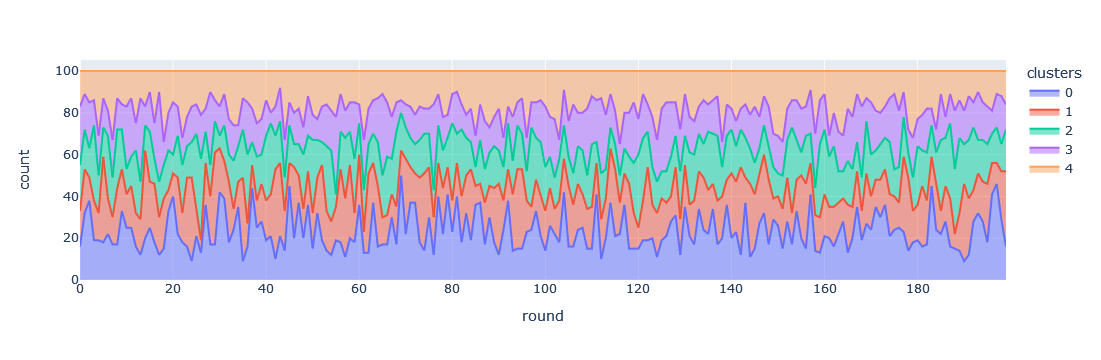

In [29]:
import plotly.express as px
import plotly.graph_objects as go

px.area(df.query("imbalance_val == 0.1"), x="round", y="count", color="clusters")

/home/lukas/Work/masterthesis-clustered-fl/.venv/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



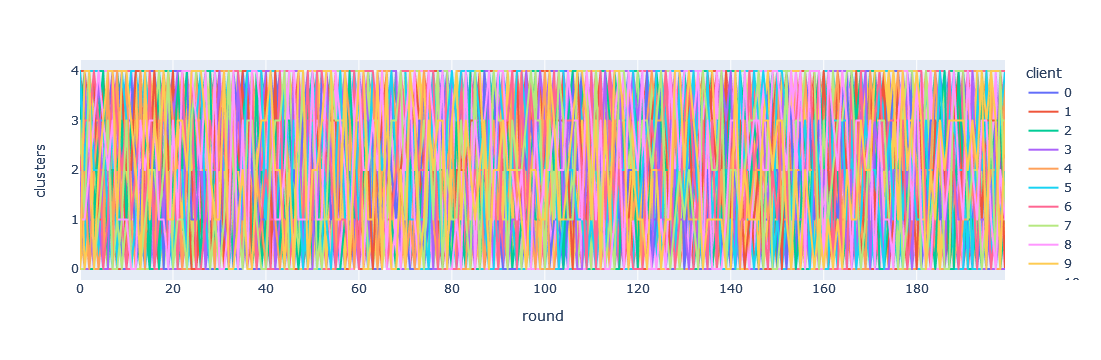

In [30]:
px.line(ca_ifca.query("imbalance_val == 0.1"), x="round", y="clusters", color="client")

/home/lukas/Work/masterthesis-clustered-fl/.venv/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



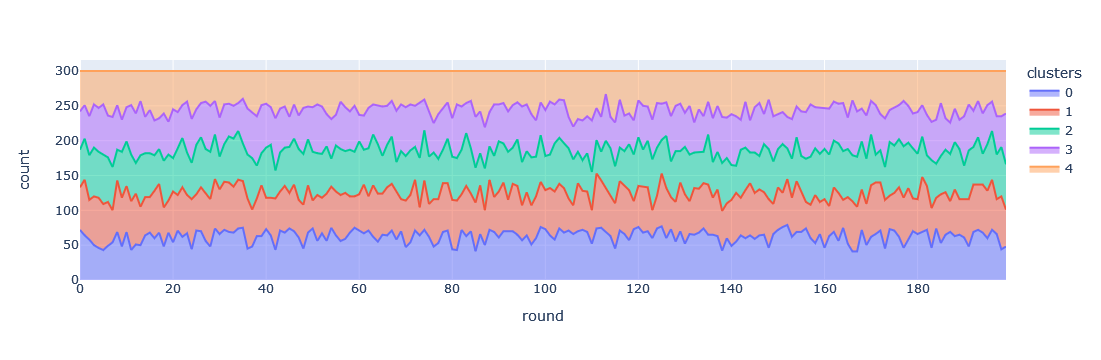

In [31]:
df = ca_flsc.groupby(["round", "algorithm", "imbalance", "imbalance_val", "clusters"]).size().reset_index().rename(columns={0: 'count'})
px.area(df.query("imbalance_val == 0.1"), x="round", y="count", color="clusters")

In [32]:
cluster_assignments.query("algorithm == 'FLSC'")

,round,client,algorithm,imbalance,imbalance_val,clusters
5,0,0,FLSC,label_distribution,0.1,"[4, 0, 4]"
12,0,1,FLSC,label_distribution,0.1,"[4, 1, 2]"
19,0,2,FLSC,label_distribution,0.1,"[3, 1, 0]"
26,0,3,FLSC,label_distribution,0.1,"[3, 1, 1]"
33,0,4,FLSC,label_distribution,0.1,"[2, 0, 0]"
...,...,...,...,...,...,...
139970,199,95,FLSC,label_distribution,1.0,"[2, 4, 0]"
139977,199,96,FLSC,label_distribution,1.0,"[4, 3, 1]"
139984,199,97,FLSC,label_distribution,1.0,"[0, 1, 4]"
139991,199,98,FLSC,label_distribution,1.0,"[1, 0, 2]"
